# Faiss centroid clustering
PaCMAP repo: https://github.com/YingfanWang/PaCMAP

Converting distances into probabilities

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark

spark = get_spark(cores=4)
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/19 18:24:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/19 18:24:57 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Sat Apr 19 06:24:59 PM EDT 2025


### Faiss centroid embeddings

In [4]:
# Path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/embeddings"


# Define the path to the train and test parquet files
def get_faiss_embed_path(num_centroids: int = 10):
    return f"{data_path}/train_centroids/num_centroids={num_centroids}"


# Read the parquet files into a spark DataFrame
faiss10_df = spark.read.parquet(get_faiss_embed_path(10))
faiss20_df = spark.read.parquet(get_faiss_embed_path(20))
faiss50_df = spark.read.parquet(get_faiss_embed_path(50))

# Show the data
faiss10_df.printSchema()
faiss10_df.show(n=5)

root
 |-- centroid_id: integer (nullable = true)
 |-- species_id: integer (nullable = true)
 |-- embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)

+-----------+----------+--------------------+
|centroid_id|species_id|           embedding|
+-----------+----------+--------------------+
|          6|   1398243|[1.0948665, -0.35...|
|          7|   1647175|[-0.30202305, 0.7...|
|          3|   1360020|[0.049416766, 0.9...|
|          3|   1361527|[0.3046188, 0.885...|
|          8|   1359277|[-0.09973065, 0.6...|
+-----------+----------+--------------------+
only showing top 5 rows



In [5]:
# select unique species_id and count
faiss10_df.select("species_id").distinct().count()

7806

In [6]:
import pacmap
import numpy as np


df = faiss10_df
X = np.stack(df.select("embedding").toPandas().embedding.values)
reducer = pacmap.PaCMAP(n_components=2, random_state=42)
g = reducer.fit_transform(X)

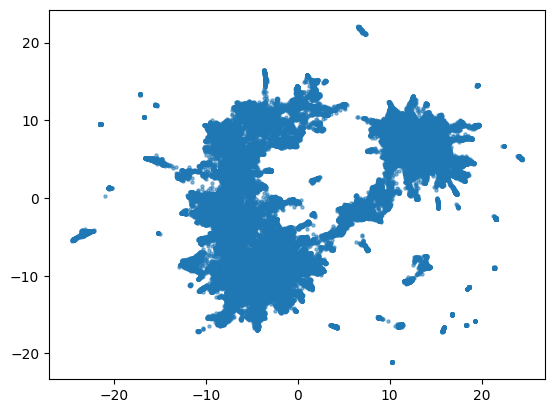

In [7]:
import matplotlib.pyplot as plt


plt.scatter(g[:, 0], g[:, 1], s=5, alpha=0.5)
plt.show()

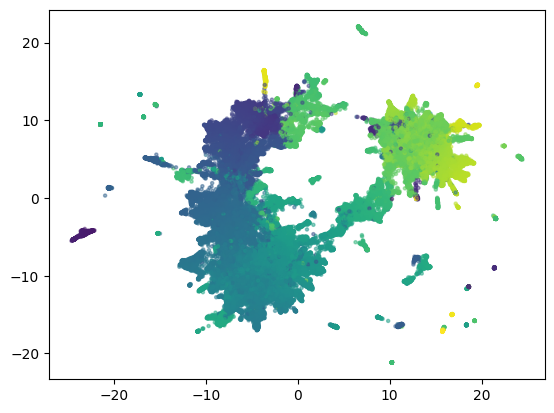

In [8]:
reducer = pacmap.PaCMAP(n_components=1, random_state=42)
g2 = reducer.fit_transform(X)
plt.scatter(g[:, 0], g[:, 1], s=5, alpha=0.5, c=g2)
plt.show()

In [9]:
g2

array([[-22.08946  ],
       [ 41.432682 ],
       [  1.984858 ],
       ...,
       [  3.0205126],
       [ -2.475171 ],
       [ -8.566512 ]], dtype=float32)

In [10]:
test_path = f"{data_path}/test_2025/test_2025_embed_logits"
test_df = spark.read.parquet(test_path)
test_df.printSchema()

root
 |-- image_name: string (nullable = true)
 |-- output: struct (nullable = true)
 |    |-- cls_token: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |    |-- logits: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |-- sample_id: integer (nullable = true)



In [11]:
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, FloatType


def avg_embeddings_udf(embeddings):
    array = np.array(embeddings)
    mean_array = np.mean(array, axis=0)
    return mean_array.tolist()


average_embeddings = F.udf(avg_embeddings_udf, ArrayType(FloatType()))

# group and apply the UDF
avg_embeddings_df = (
    faiss10_df.groupBy("species_id")
    .agg(F.collect_list("embedding").alias("embedding_list"))
    .withColumn("avg_embeddings", average_embeddings(F.col("embedding_list")))
)
avg_embeddings_df.printSchema()
avg_embeddings_df.show(n=10, truncate=50)

root
 |-- species_id: integer (nullable = true)
 |-- embedding_list: array (nullable = false)
 |    |-- element: array (containsNull = false)
 |    |    |-- element: float (containsNull = true)
 |-- avg_embeddings: array (nullable = true)
 |    |-- element: float (containsNull = true)



+----------+--------------------------------------------------+--------------------------------------------------+
|species_id|                                    embedding_list|                                    avg_embeddings|
+----------+--------------------------------------------------+--------------------------------------------------+
|   1355869|[[0.0038829704, -0.013802218, 0.009791469, 0.36...|[0.114047855, 0.4057617, -0.06062866, 0.0549097...|
|   1355870|[[0.18335515, -0.08915622, -0.29222322, 0.81695...|[0.11070547, 0.28042978, -0.69385886, 0.3224701...|
|   1355872|[[0.28893483, 0.20109488, 0.24363865, 0.2530085...|[0.19194208, 0.1617909, -0.013561882, 0.1457786...|
|   1355881|[[0.23531002, -0.26157096, -0.017927974, -1.038...|[0.20774464, -0.2938113, 0.026279427, -0.838810...|
|   1355900|[[1.0873219, -0.07327607, -0.29321098, 0.071418...|[0.5382732, 0.15868045, -0.116654, 0.23893037, ...|
|   1355953|[[-0.4760781, 1.7744097, -1.1470047, -0.3837139...|[-0.016290855, 0.

In [12]:
X = np.stack(
    avg_embeddings_df.select("avg_embeddings").toPandas().avg_embeddings.values
)
reducer = pacmap.PaCMAP(n_components=2, random_state=42)
g = reducer.fit_transform(X)

In [13]:
X_test = np.stack(test_df.select("output.cls_token").toPandas()["cls_token"].values)
reducer = pacmap.PaCMAP(n_components=2, random_state=42)
g_test = reducer.fit_transform(X_test)

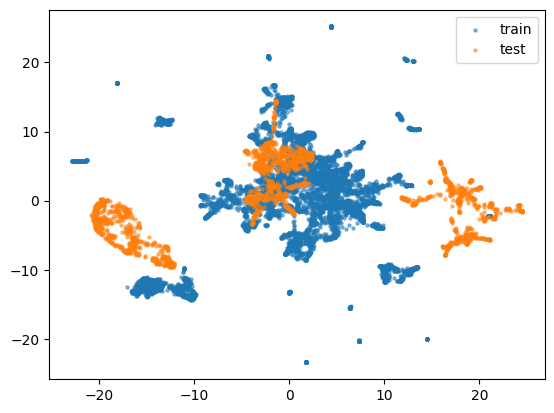

In [14]:
x1 = g[:, 0]
y1 = g[:, 1]
x2 = g_test[:, 0]
y2 = g_test[:, 1]
plt.scatter(x1, y1, s=5, alpha=0.5, label="train")
plt.scatter(x2, y2, s=5, alpha=0.5, label="test")
plt.legend()
plt.show()

In [15]:
len(g)

7806

### classifier-based probabilities

Calculate probabilities based on embedding distances

In [16]:
# train: shape (num_species, embedding_dim)
train_embeddings = np.stack(
    avg_embeddings_df.select("avg_embeddings").toPandas().avg_embeddings.values
)

# test: shape (num_test, embedding_dim)
test_embeddings = np.stack(
    test_df.select("output.cls_token").toPandas()["cls_token"].values
)

In [17]:
avg_embeddings_df.printSchema()
display(avg_embeddings_df.count())
test_df.printSchema()
display(test_df.count())

root
 |-- species_id: integer (nullable = true)
 |-- embedding_list: array (nullable = false)
 |    |-- element: array (containsNull = false)
 |    |    |-- element: float (containsNull = true)
 |-- avg_embeddings: array (nullable = true)
 |    |-- element: float (containsNull = true)



7806

root
 |-- image_name: string (nullable = true)
 |-- output: struct (nullable = true)
 |    |-- cls_token: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |    |-- logits: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |-- sample_id: integer (nullable = true)



2105

In [18]:
7806 * 2105

16431630

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# cosine similarity between test and train embeddings
# shape: (num_test, num_species)
similarities = cosine_similarity(test_embeddings, train_embeddings)

In [20]:
from scipy.special import softmax

# Apply softmax across each row to get pseudo-probabilities over species
probabilities = softmax(similarities, axis=1)  # shape: (num_test, num_species)

In [21]:
# extract species IDs and probabilities
species_ids = avg_embeddings_df.select("species_id").toPandas()["species_id"].values

# extract test embeddings and image names
image_names = test_df.select("image_name").toPandas()["image_name"].values

In [22]:
import pandas as pd


# map probabilities to species_id using a DataFrame
proba_df = pd.DataFrame(
    {
        "image_name": image_names,
        "probabilities": list(probabilities),
    }
)
proba_df.head()

,image_name,probabilities
0,CBN-Pla-A1-20190814.jpg,"[0.00013364568, 0.0001370426, 0.00013328422, 0..."
1,CBN-Pla-D6-20190814.jpg,"[0.00012812452, 0.0001313897, 0.0001284744, 0...."
2,CBN-PdlC-C5-20140901.jpg,"[0.0001306982, 0.00013256918, 0.00012960914, 0..."
3,LISAH-BOU-0-37-20230512.jpg,"[0.00013178964, 0.0001346425, 0.00014256526, 0..."
4,CBN-Pla-E4-20130808.jpg,"[0.00013026498, 0.00012689614, 0.00012781844, ..."


In [23]:
proba_df.shape

(2105, 2)

In [24]:
from plantclef.config import get_class_mappings_file

# Load species_ids in the correct order
class_mappings_file = get_class_mappings_file()
with open(class_mappings_file) as f:
    sorted_species_ids = np.array([int(line.strip()) for line in f])

display(sorted_species_ids[:10])

# species_id to index mapping
species_id_to_index = {
    species_id: idx for idx, species_id in enumerate(sorted_species_ids)
}

# original_species_ids = species_ids from avg_embeddings_df
original_species_ids = (
    avg_embeddings_df.select("species_id").toPandas()["species_id"].values
)
# create an array of indices to re-order the columns
column_reorder_indices = [
    np.where(original_species_ids == sid)[0][0] for sid in sorted_species_ids
]

# reorder the columns of the probability matrix
sorted_probabilities = probabilities[:, column_reorder_indices]

# create the DataFrame
final_df = pd.DataFrame(
    {
        "image_name": image_names,
        "probabilities": list(sorted_probabilities),  # store vectors
    }
)
final_df.head()

array([1355868, 1355869, 1355870, 1355871, 1355872, 1355873, 1355880,
       1355881, 1355882, 1355884])

,image_name,probabilities
0,CBN-Pla-A1-20190814.jpg,"[0.00013234721, 0.00012035529, 0.00012586203, ..."
1,CBN-Pla-D6-20190814.jpg,"[0.00013238179, 0.00012068612, 0.00012430409, ..."
2,CBN-PdlC-C5-20140901.jpg,"[0.00013084458, 0.00012031096, 0.000125613, 0...."
3,LISAH-BOU-0-37-20230512.jpg,"[0.00011587113, 0.00012632042, 0.00013190121, ..."
4,CBN-Pla-E4-20130808.jpg,"[0.00013049232, 0.00011688124, 0.00012663532, ..."


### write to parquet

In [41]:
# convert pandas to spark DataFrame
final_spark_df = spark.createDataFrame(final_df)
final_spark_df.printSchema()
final_spark_df.show(n=5, truncate=50)

# write the DataFrame to parquet
folder_name = "test_2025_centroid_probabilities"
output_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/clustering/{folder_name}"
final_spark_df.write.mode("overwrite").parquet(output_path)
print(f"Probabilities saved to {output_path}")

root
 |-- image_name: string (nullable = true)
 |-- probabilities: array (nullable = true)
 |    |-- element: float (containsNull = true)

+---------------------------+--------------------------------------------------+
|                 image_name|                                     probabilities|
+---------------------------+--------------------------------------------------+
|    CBN-Pla-A1-20190814.jpg|[1.3234721E-4, 1.2035529E-4, 1.2586203E-4, 1.24...|
|    CBN-Pla-D6-20190814.jpg|[1.3238179E-4, 1.2068612E-4, 1.2430409E-4, 1.27...|
|   CBN-PdlC-C5-20140901.jpg|[1.3084458E-4, 1.2031096E-4, 1.25613E-4, 1.2224...|
|LISAH-BOU-0-37-20230512.jpg|[1.1587113E-4, 1.2632042E-4, 1.3190121E-4, 1.29...|
|    CBN-Pla-E4-20130808.jpg|[1.3049232E-4, 1.1688124E-4, 1.2663532E-4, 1.26...|
+---------------------------+--------------------------------------------------+
only showing top 5 rows



Probabilities saved to /storage/home/hcoda1/9/mgustineli3/p-dsgt_clef2025-0/shared/plantclef/data/clustering/test_2025_centroid_probabilities


### get top-K species predictions

In [ ]:
top_k = 10
probabilities = final_df["probabilities"].iloc[0]
display(probabilities)
top_k_preds = np.argsort(-probabilities)[:top_k]
top_k_species = species_ids[top_k_preds]

array([0.00013235, 0.00012036, 0.00012586, ..., 0.00012737, 0.00011966,
       0.00011363], dtype=float32)

array([1458093, 1441034, 1358575, 1360716, 1356284, 1390966, 1564323,
       1396802, 1392484, 1359740], dtype=int32)

In [37]:
num_classes = 10
ids = ["id_" + str(x) for x in range(num_classes)]
display(ids)
np.random.seed(42)
x1 = np.random.rand(num_classes)
x2 = np.random.rand(num_classes)
display(x1, x2)


def vec_to_list_dict(arr: np.ndarray) -> list[dict]:
    return [{"id": str(i), "proba": float(v)} for i, v in enumerate(arr)]


def list_dict_to_vec(d: list[dict]) -> np.ndarray:
    # sort based on position in ids
    d = sorted(d, key=lambda x: id.index(x["id"]))
    return np.array([x["proba"] for x in d], dtype=np.float)


g1 = vec_to_list_dict(x1 * x2 / x2.sum())
g1 = sorted(g1, key=lambda x: x["proba"], reverse=True)
display(g1)
pd.DataFrame(g1).sort_values("proba", ascending=False).iloc[:5]

['id_0',
 'id_1',
 'id_2',
 'id_3',
 'id_4',
 'id_5',
 'id_6',
 'id_7',
 'id_8',
 'id_9']

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258])

array([0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497,
       0.18340451, 0.30424224, 0.52475643, 0.43194502, 0.29122914])

[{'id': '1', 'proba': 0.23328666719052332},
 {'id': '2', 'proba': 0.15415951084509974},
 {'id': '7', 'proba': 0.11499329225786391},
 {'id': '8', 'proba': 0.06568928916650123},
 {'id': '9', 'proba': 0.05217003427084131},
 {'id': '3', 'proba': 0.032160119544086145},
 {'id': '5', 'proba': 0.007238154887853418},
 {'id': '4', 'proba': 0.007176926946965479},
 {'id': '6', 'proba': 0.004470763016682817},
 {'id': '0', 'proba': 0.0019505049850556957}]

,id,proba
0,1,0.233287
1,2,0.154160
2,7,0.114993
3,8,0.065689
4,9,0.052170
